## Imports


In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset

In [3]:
IN_CHANNELS = 3
IMG_SIZE = (64, 64)
BATCH_SIZE = 128

In [4]:
CelebA_labels= pd.read_csv('./CelebA/list_attr_celeba.csv')
CelebA_smile = CelebA_labels[['image_id', 'Smiling']]
CelebA_smile['Smiling'] = CelebA_smile['Smiling'].replace(-1, 0)
CelebA_smile.to_csv('./CelebA/CelebA_smile.csv', index=False)
CelebA_smile.head()

C:\Users\fatemeh\AppData\Local\Temp\ipykernel_22572\4201292190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CelebA_smile['Smiling'] = CelebA_smile['Smiling'].replace(-1, 0)


image_id  Smiling
0  000001.jpg        1
1  000002.jpg        1
2  000003.jpg        0
3  000004.jpg        0
4  000005.jpg        0

In [5]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(IN_CHANNELS)], [0.5 for _ in range(IN_CHANNELS)])
])

In [6]:
class CelebADataset(Dataset):
    def __init__(self, image_folder, csv_file, transform=None):
        self.image_folder = image_folder
        self.labels_df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, index):
        img_name = self.labels_df.iloc[index, 0]
        img_path = os.path.join(self.image_folder, img_name)
        label = self.labels_df.iloc[index, 1]

        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


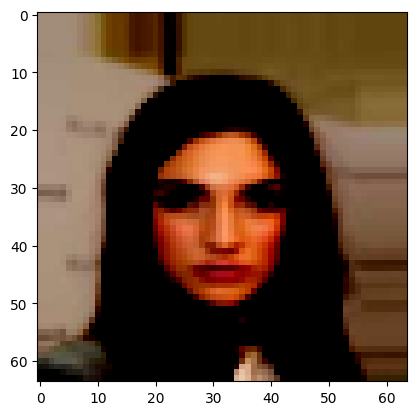

In [7]:
image_folder = "./CelebA/img_align_celeba/img_align_celeba/"
csv_file = "./CelebA/CelebA_smile.csv"

dataset = CelebADataset(image_folder, csv_file, transform=transform)
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

batch = next(iter(loader))
images, labels = batch
sample = images[1].permute(1, 2, 0).numpy()
plt.imshow(sample)

## Generator Model

In [8]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
       
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

## Classifier


In [9]:
class Classifier(nn.Module):
    
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.Sigmoid()
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

In [10]:
n_epochs = 15
lr = 0.001
beta_1 = 0.5
beta_2 = 0.999


In [11]:
classifier = Classifier(n_classes=1).to(device)
class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
criterion = nn.BCELoss()

In [12]:
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for i, (real, labels) in enumerate(loader):
        real = real.to(device)
        labels = labels.view(labels.shape[0], -1).float().to(device)
        class_opt.zero_grad()
        class_pred = classifier(real)
        class_loss = criterion(class_pred, labels)
        class_loss.backward() # Calculate the gradients
        class_opt.step() # Update the weights

        if i == 0:
            print(
                f"Epoch [{epoch+1}/{n_epochs}] Batch {i}/{len(loader)} \
                      Loss Classifier: {class_loss:.4f}"
            )


Epoch [1/15] Batch 0/1583                       Loss Classifier: 0.7240
Epoch [2/15] Batch 0/1583                       Loss Classifier: 0.2382
Epoch [3/15] Batch 0/1583                       Loss Classifier: 0.1538
Epoch [4/15] Batch 0/1583                       Loss Classifier: 0.1503
Epoch [5/15] Batch 0/1583                       Loss Classifier: 0.0842
Epoch [6/15] Batch 0/1583                       Loss Classifier: 0.1614
Epoch [7/15] Batch 0/1583                       Loss Classifier: 0.0926
Epoch [8/15] Batch 0/1583                       Loss Classifier: 0.1133
Epoch [9/15] Batch 0/1583                       Loss Classifier: 0.0924
Epoch [10/15] Batch 0/1583                       Loss Classifier: 0.0627
Epoch [11/15] Batch 0/1583                       Loss Classifier: 0.0503
Epoch [12/15] Batch 0/1583                       Loss Classifier: 0.1407
Epoch [13/15] Batch 0/1583                       Loss Classifier: 0.0664
Epoch [14/15] Batch 0/1583                       Loss Classi

In [13]:
CelebA_classifire_path = './CelebA_classifier.pth'
torch.save(classifier.state_dict(), CelebA_classifire_path)

## Load Models

In [14]:
# Generator
z_dim = 64
gen = Generator(z_dim=z_dim).to(device)
gen_dict = torch.load("pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 512, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

In [15]:
#Classifier
classifier = Classifier(n_classes=1).to(device)
classifier_dict = torch.load("./CelebA_classifier.pth")
classifier.load_state_dict(classifier_dict)
classifier.eval()

Classifier(
  (classifier): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Sigmoid()
    )
  )
)

## calculate_updated_noise

In [16]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [17]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

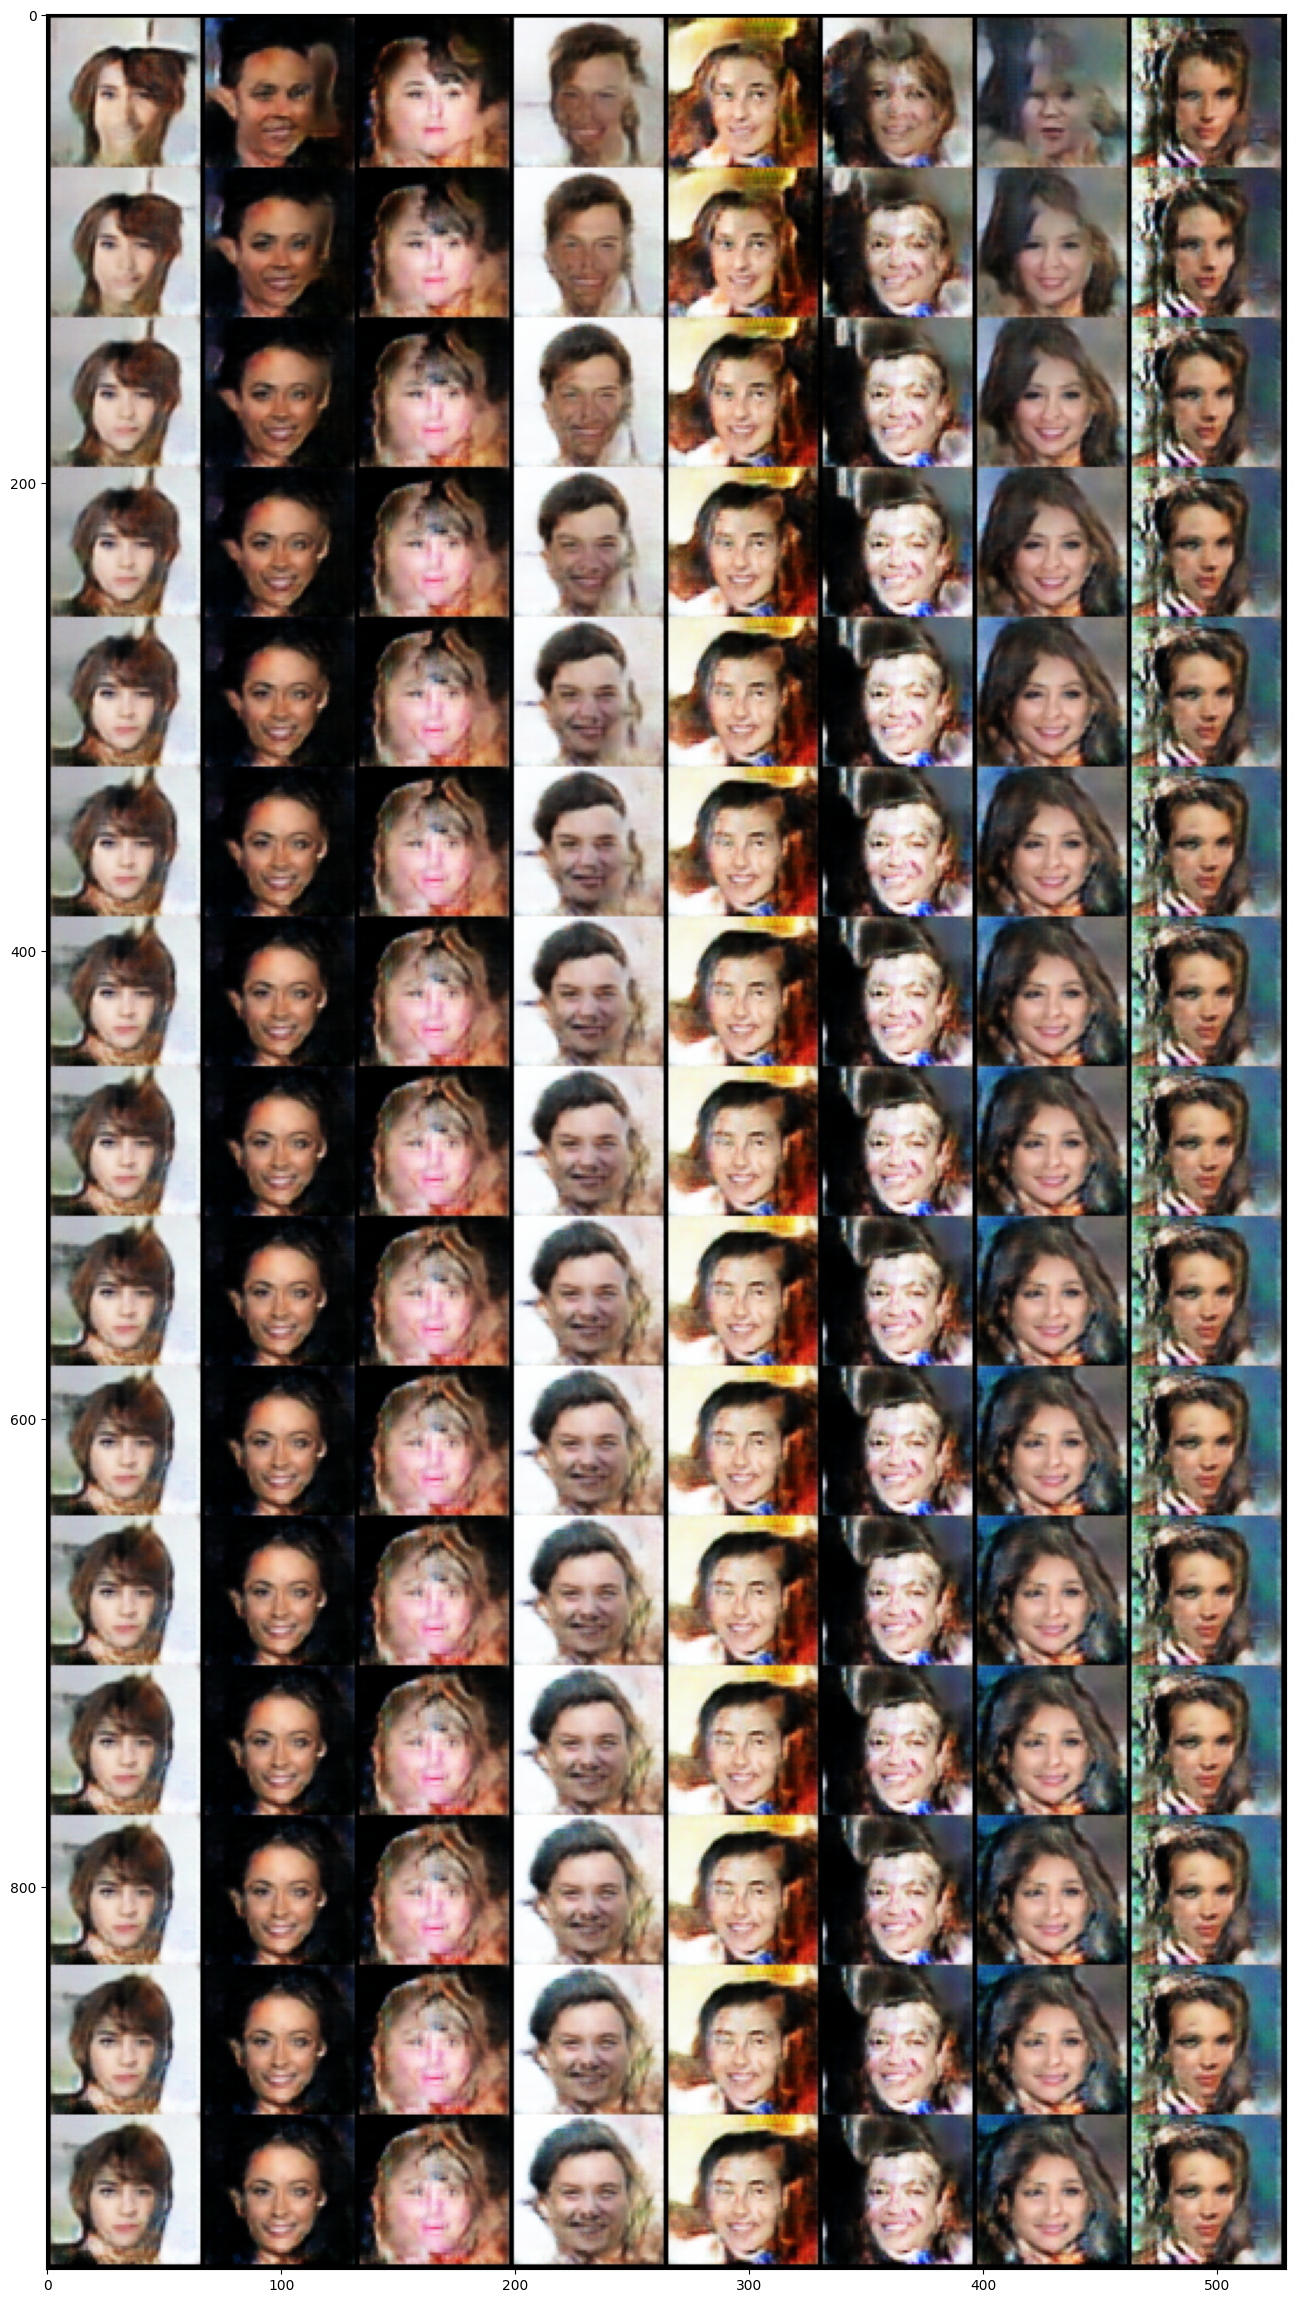

In [123]:
z_dim = 64
skip = 2
fake_image_history = []
update_steps =30

noise = get_noise(8, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()

opt = torch.optim.Adam([noise], lr=0.1)

for i in range(update_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake).mean() * -1
    fake_classes_score.backward()
    opt.step()


plt.rcParams['figure.figsize'] = [8 * 2, update_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=32, nrow=32)